In [1]:
import datetime
import itertools

from pymongo import MongoClient, IndexModel
import pymongo
import pandas as pd
import numpy as np

We'll send querys on the fields `created_utc` (numeric) and `author` (string). To speed up the query, we need to create `pymongo.ASCENDING` and `pymong.HASHED` indexes on these fields.

In [2]:
client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]

In [3]:
db["MensRights"].drop_indexes()
db["MensRights"].create_index([("created_utc", pymongo.ASCENDING)])
db["MensRights"].create_index([("author", pymongo.HASHED)])

db["Feminism"].drop_indexes()
db["Feminism"].create_index([("created_utc", pymongo.ASCENDING)])
db["Feminism"].create_index([("author", pymongo.HASHED)])

u'author_hashed'

In [4]:
mensrights = list(db["MensRights"].find({}, {"date": 1, "author": 1, "_id": 1}))
mensrights = pd.DataFrame(mensrights)
mensrights = mensrights.groupby(["date", "author"]).apply(lambda df: list(df["_id"].values))
mensrights = mensrights.reset_index()

In [5]:
feminism = list(db["Feminism"].find({}, {"date": 1, "author": 1, "_id": 1}))
feminism = pd.DataFrame(feminism)
feminism = feminism.groupby(["date", "author"]).apply(lambda df: list(df["_id"].values))
feminism = feminism.reset_index()

In [6]:
def func(row, opposite_sr, radius=5):
    date = row["date"]
    author = row["author"]
    if date.month == 1 and date.day == 1:
        if date not in printed:
            print date
            printed.add(date)
    low = date + datetime.timedelta(days=-radius)
    high = date + datetime.timedelta(days=radius)
    
    query = db[opposite_sr].find_one({"author": author, "created_utc": {"$lte": high, "$gte": low}})
    return True if query else False

In [7]:
printed = set()
mensrights["is_cp"] = mensrights.apply(lambda row: func(row, "Feminism"), axis=1)

2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [8]:
printed = set()
feminism["is_cp"] = feminism.apply(lambda row: func(row, "MensRights"), axis=1)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [9]:
mensrights.columns = ["date", "author", "_ids", "is_cp"]
mensrights[:3]

,date,author,_ids,is_cp
0,2008-03-21,kanuk876,[57c657db79a3030ce0379124],False
1,2008-03-24,WorcesterM,[57c657dc79a3030ce0380a72],False
2,2008-03-25,WorcesterM,[57c657dc79a3030ce0385021],False


In [10]:
mensrights["is_cp"].sum()

27644

In [11]:
mensrights.shape

(910294, 4)

In [12]:
mensrights.iloc[0, :].values

array([Timestamp('2008-03-21 00:00:00'), u'kanuk876',
       [ObjectId('57c657db79a3030ce0379124')], False], dtype=object)

In [13]:
feminism.columns = ["date", "author", "_ids", "is_cp"]
feminism[:3]

,date,author,_ids,is_cp
0,2009-02-06,stellar1,[57c6557c79a3030ce01841b0],False
1,2009-04-13,Smight,[57c655c379a3030ce039f495],False
2,2009-04-30,alexs,[57c655d779a3030ce04429e4],False


In [14]:
feminism["is_cp"].sum()

15707

In [15]:
feminism.shape

(107881, 4)

In [16]:
feminism.iloc[0, :].values

array([Timestamp('2009-02-06 00:00:00'), u'stellar1',
       [ObjectId('57c6557c79a3030ce01841b0')], False], dtype=object)

In [17]:
db.collection_names()

[u'Cooking', u'Feminism', u'MensRights']

In [18]:
mensrights_is_cp = mensrights.T.to_dict().values()
mensrights_is_cp = map(lambda doc: {"_ids": doc["_ids"], 
                                    "author": doc["author"],
                                    "date": doc["date"].to_pydatetime(),
                                    "is_cp": doc["is_cp"]}, mensrights_is_cp)
db["mensrights_is_cp"].insert_many(mensrights_is_cp)

In [19]:
feminism_is_cp = feminism.T.to_dict().values()
feminism_is_cp = map(lambda doc: {"_ids": doc["_ids"], 
                                  "author": doc["author"],
                                  "date": doc["date"].to_pydatetime(),
                                  "is_cp": doc["is_cp"]}, feminism_is_cp)
db["feminism_is_cp"].insert_many(feminism_is_cp)

In [20]:
del mensrights, feminism, mensrights_is_cp, feminism_is_cp

In [3]:
mensrights_is_cp = pd.DataFrame(list(db["mensrights_is_cp"].find({"is_cp": True}, {"_id": 0})))
feminism_is_cp = pd.DataFrame(list(db["feminism_is_cp"].find({"is_cp": True}, {"_id": 0})))

In [4]:
mensrights_is_cp[:5]

,_ids,author,date,is_cp
0,[57c655e479a3030ce04a8eb8],darkreign,2009-05-10,True
1,"[57c6562779a3030ce06a40d1, 57c6562779a3030ce06...",darkreign,2009-07-01,True
2,"[57c6562e79a3030ce06db169, 57c6562f79a3030ce06...",AnnArchist,2009-07-06,True
3,"[57c6562f79a3030ce06e2f4a, 57c6563079a3030ce06...",AnnArchist,2009-07-07,True
4,"[57c6563279a3030ce06ef7a0, 57c6563279a3030ce06...",AnnArchist,2009-07-08,True


In [5]:
mensrights_is_cp.shape

(27644, 4)

In [6]:
feminism_is_cp[:5]

,_ids,author,date,is_cp
0,[57c655e479a3030ce04ab7fa],darkreign,2009-05-11,True
1,[57c6562879a3030ce06af9d6],darkreign,2009-07-02,True
2,[57c6563479a3030ce0701e1f],AnnArchist,2009-07-09,True
3,[57c6563879a3030ce071e829],AnnArchist,2009-07-12,True
4,[57c6565f79a3030ce0857526],Cassio,2009-08-07,True


In [7]:
feminism_is_cp.shape

(15707, 4)

### Crossposter

In [8]:
def pos_filter(x, keep=set("NJ")):
    if len(x) == 0:
        return ""
    
    tokens_pos = x.split(" ")
    tokens_pos = map(lambda pair: pair.split("/"), tokens_pos)
    
    tokens_pos = filter(lambda pair: pair[1] in keep, tokens_pos)

    if len(tokens_pos) == 0:
        return ""
    
    return " ".join(zip(*tokens_pos)[0])

In [9]:
def get_crosspost_corpus(df, subreddit, filter_date=None, group_author=False):
    if filter_date:
        low = filter_date[0]
        high = filter_date[1]
        df = df[(df["date"] <= high) & (df["date"] >= low)]
    
    if group_author:
        out = df.groupby("author").apply(lambda x: list(itertools.chain(*x["_ids"].values)))
        out = out.reset_index(drop=True)
    else:
        out = pd.Series(list(itertools.chain(*df["_ids"].values)))
        out = out.map(lambda x: [x])
        
    objectid2tokens = lambda objectid: pos_filter(db[subreddit].find_one({"_id": objectid},
                                                                         {"tokens_njv_pos": 1, "_id": 0})["tokens_njv_pos"])
    
    # Map each ObjectId to the `tokens_njv` field
    out = out.map(lambda ids: map(objectid2tokens, ids))
    # Join the strings (`tokens_njv`) on space " "
    out = out.map(lambda token_lists: " ".join(token_lists))
    # Filter out empty tokens 
    out = out.map(lambda text: filter(lambda token: len(token) > 0, text.split(" ")))
    out.index.name = "corpus"
    
    return out    

In [10]:
low = datetime.datetime(2011, 3, 1)
high = datetime.datetime(2011, 8, 1)

crosspost_corpus_men = get_crosspost_corpus(mensrights_is_cp, "MensRights",
                                            filter_date=[low, high], group_author=False)
crosspost_corpus_fem = get_crosspost_corpus(feminism_is_cp, "Feminism",
                                            filter_date=[low, high], group_author=False)

In [11]:
crosspost_corpus_men[:5]

corpus
0       [freedom, paternity, test, woman, man, father]
1                 [eddie, much, troll, long, as, time]
2                                                   []
3    [shit, everybody, creepy, fat, men, pedos, ska...
4    [dumb, feminist, information, shit, pua, men, ...
dtype: object

In [12]:
crosspost_corpus_fem[:5]

corpus
0    [guess, dark, corner, end, men, futurama, epis...
1    [woman, bad, men, men, anybody, woman, anybody...
2    [woman, sex, bad, men, need, conversation, end...
3    [people, feminism, feminism, pretty, basic, co...
4    [main, misogynistic, argument, feminism, men, ...
dtype: object

### Non crossposter

In [13]:
men_authors = list(db["MensRights"].find({}, {"author": 1, "_id": 0}))
men_authors = set(map(lambda doc: doc["author"], men_authors))
    
fem_authors = list(db["Feminism"].find({}, {"author": 1, "_id": 0}))
fem_authors = set(map(lambda doc: doc["author"], fem_authors))
    
men_only = list(men_authors - fem_authors)
fem_only = list(fem_authors - men_authors)

In [14]:
len(men_only), len(fem_only)

(106257, 22955)

In [15]:
def get_noncrosspost_corpus(authors, subreddit, filter_date=None, group_author=False):
    if filter_date:
        low = filter_date[0]
        high = filter_date[1]
        df = pd.DataFrame(list(db[subreddit].find({"created_utc": {"$lte": high, "$gte": low},
                                                   "author": {"$in": authors}} ,
                                                  {"author": 1, "date": 1, "tokens_njv_pos": 1, "_id": 0})))
    else:
        df = pd.DataFrame(list(db[subreddit].find({"author": {"$in": authors}},
                                                  {"author": 1, "date": 1, "tokens_njv_pos": 1, "_id": 0})))
        
    if group_author:
        out = df.groupby("author").apply(lambda x: " ".join(x["tokens_njv_pos"].values))
        out = out.reset_index(drop=True)
    else:
        out = df["tokens_njv_pos"]
        
    out = out.map(pos_filter)    
    out = out.map(lambda text: filter(lambda token: len(token) > 0, text.split(" ")))
    out.index.name = "corpus"
        
    return out  

In [16]:
low = datetime.datetime(2014, 1, 1)
high = datetime.datetime(2016, 7, 31)

noncrosspost_corpus_men = get_noncrosspost_corpus(men_only, "MensRights",
                                                  filter_date=[low, high], group_author=False)
noncrosspost_corpus_fem = get_noncrosspost_corpus(fem_only, "Feminism",
                                                  filter_date=[low, high], group_author=False)

In [17]:
noncrosspost_corpus_men[:5]

corpus
0    [update, rmensrights, dead, wrong, anyone, sli...
1                          [guess, entire, post, part]
2    [nobody, perfect, rationalist, negative, perfe...
3    [quote, strickland, didnt, register, hutchins,...
4    [segregation, retaliation, see, civil, right, ...
Name: tokens_njv_pos, dtype: object

In [18]:
noncrosspost_corpus_fem[:5]

corpus
0    [man, men, problem, womenminorities, number, r...
1    [woman, option, prostitute, enough, money, fam...
2    [woman, mad, men, glance, longing, creepy, stare]
3    [pointless, waste, money, everyone, unhappy, c...
4            [belong, content, woman, right, activist]
Name: tokens_njv_pos, dtype: object

In [19]:
len(crosspost_corpus_men), len(crosspost_corpus_fem), len(noncrosspost_corpus_men), len(noncrosspost_corpus_fem)

(9119, 1996, 805052, 52870)

In [22]:
def fil(corpus):
    return filter(lambda tokens: len(tokens) >= 20, corpus)

In [23]:
len(fil(crosspost_corpus_men)), len(fil(crosspost_corpus_fem)), len(fil(noncrosspost_corpus_men)), len(fil(noncrosspost_corpus_fem))

(2423, 703, 174220, 14594)

In [44]:
size = 4000

def sample_corpus(*args):
#    crosspost_corpus_men_f = fil(args[0])
#    crosspost_corpus_fem_f = fil(args[1])
    crosspost_corpus_men_f = fil(args[2])
    crosspost_corpus_fem_f = fil(args[3])
    
#    corpus_A =  list(np.random.choice(crosspost_corpus_men_f, size, replace=False)) + \
#                       list(np.random.choice(crosspost_corpus_fem_f, size, replace=False))
    
#    corpus_B = list(np.random.choice(noncrosspost_corpus_men_f, size, replace=False)) + \
#                          list(np.random.choice(noncrosspost_corpus_fem_f, size, replace=False))

#    crosspost_corpus = list(np.random.choice(noncrosspost_corpus_men_f, size, replace=False))
#    noncrosspost_corpus = list(np.random.choice(noncrosspost_corpus_fem_f, size, replace=False))
 
    corpus_A = np.random.choice(noncrosspost_corpus_men_f, len(noncrosspost_corpus_men_f), replace=False)
    corpus_B = np.random.choice(noncrosspost_corpus_fem_f, len(noncrosspost_corpus_fem_f), replace=False)
    return corpus_A, corpus_B    

In [45]:
corpus_A, corpus_B = sample_corpus(crosspost_corpus_men,
                                                      crosspost_corpus_fem,
                                                      noncrosspost_corpus_men,
                                                      noncrosspost_corpus_fem)

In [26]:
corpus_A = fil(crosspost_corpus_men)
corpus_B = fil(crosspost_corpus_fem)

In [27]:
len(corpus_A), len(corpus_B)

(2423, 703)

In [28]:
print corpus_A[:2]

[[u'view', u'men', u'men', u'important', u'child', u'life', u'disease', u'actual', u'father', u'able', u'medical', u'history', u'account', u'important', u'case', u'test', u'male', u'child', u'female', u'bit', u'offended'], [u'domain', u'name', u'registrant', u'contact', u'jeffrey', u'fecke', u'fax', u'kennard', u'ct', u'lakeville', u'administrative', u'contact', u'jeffrey', u'fax', u'kennard', u'ct', u'lakeville', u'technical', u'contact', u'jeffrey', u'fax', u'kennard', u'ct', u'lakeville']]


In [29]:
print corpus_B[:2]

[[u'people', u'feminism', u'feminism', u'pretty', u'basic', u'concept', u'woman', u'men', u'equal', u'opportunity', u'understanding', u'woman', u'short-changed', u'world', u'name', u'negative', u'connotation', u'woman', u'time', u'feminist', u'ridiculous', u'feminist', u'misogynist', u'book', u'way', u'claim', u'woman', u'equal', u'opportunity', u'men', u'misogynistic'], [u'feminism', u'gender', u'equality', u'woman', u'right', u'feminism', u'part', u'mission', u'men', u'right', u'issue', u'people', u'feminism', u'misogynistic', u'bolshevik', u'anarchist', u'anti-revolutionaries', u'czar', u'pointless', u'divisive', u'feminism', u'claim', u'equality', u'idea', u'patriarchy', u'try']]


In [30]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

In [31]:
vectorizer = TfidfVectorizer(max_df=0.2, max_features=5000,
                             min_df=5, stop_words='english',
                             use_idf=True)

X_cp = vectorizer.fit_transform(map(lambda x: " ".join(x), corpus_A))
X_ncp = vectorizer.fit_transform(map(lambda x: " ".join(x), corpus_B))

In [32]:
X_cp.shape, X_ncp.shape

((2423, 2747), (703, 1166))

In [52]:
LSA = Pipeline([("svd", TruncatedSVD(n_components=50)), ("normalizer", Normalizer())])

In [53]:
X_cp30 = LSA.fit_transform(X_cp)
X_ncp30 = LSA.fit_transform(X_ncp)

In [54]:
X_cp30.shape, X_ncp30.shape

((4000, 50), (4000, 50))

In [55]:
size

4000

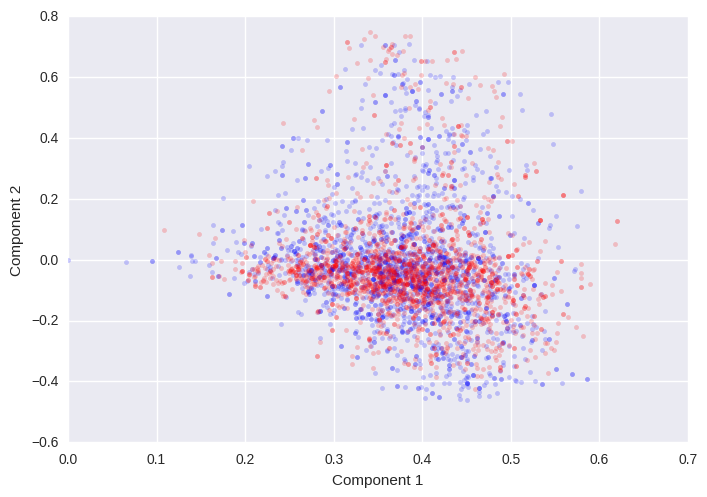

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

index = np.random.choice(size, 2000)

plt.plot(X_cp30[index, 0], X_cp30[index, 1], "b.", alpha=0.2, linewidth=0.1)
plt.plot(X_ncp30[index, 0], X_ncp30[index, 1], "r.", alpha=0.2, linewidth=0.1)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

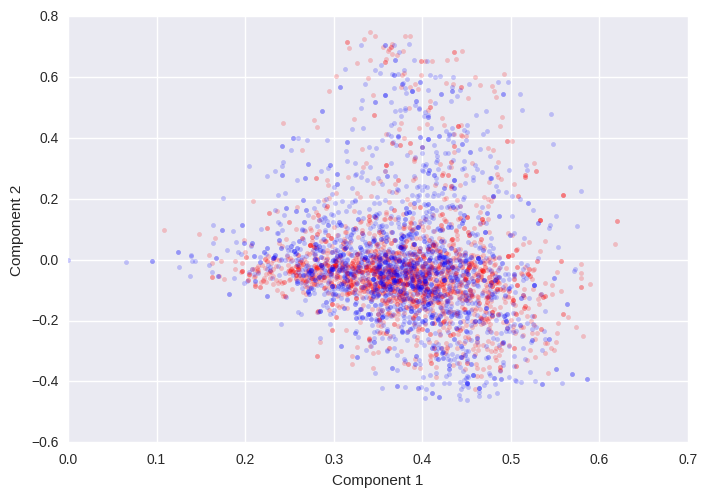

In [57]:
plt.plot(X_ncp30[index, 0], X_ncp30[index, 1], "r.", alpha=0.2, linewidth=0.1)
plt.plot(X_cp30[index, 0], X_cp30[index, 1], "b.", alpha=0.2, linewidth=0.1)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [36]:
def train_topic_model_sklearn_lda(corpus, topics):
    corpus = map(lambda tokens: " ".join(tokens), corpus)
    vectorizer = CountVectorizer(stop_words='english', lowercase=True, max_df=0.1,
                                    min_df=5, max_features=5000)
    X = vectorizer.fit_transform(corpus)
#    tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_df=0.5,
#                                       min_df=5, max_features=5000)
#    dtm_tfidf = tfidf_vectorizer.fit_transform(map(lambda tokens: " ".join(tokens), corpus))
    
    lda = LatentDirichletAllocation(n_topics=topics, random_state=0, learning_method="online", n_jobs=4)
    lda.fit(X)
    return lda, X, vectorizer

In [37]:
K = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
n_topics = 50
    
tm_corpus_A = train_topic_model_sklearn_lda(corpus_A, topics=n_topics)
tm_corpus_B = train_topic_model_sklearn_lda(corpus_B, topics=n_topics)

In [38]:
len(corpus_A), len(corpus_B)

(2423, 703)

In [39]:
import pyLDAvis
from pyLDAvis import sklearn

In [40]:
data = sklearn.prepare(tm_corpus_A[0], tm_corpus_A[1], tm_corpus_A[2])

In [41]:
pyLDAvis.display(data)

In [42]:
data = sklearn.prepare(tm_corpus_B[0], tm_corpus_B[1], tm_corpus_B[2])

In [43]:
pyLDAvis.display(data)

In [83]:
from gensim import corpora, models

In [84]:
def train_topic_model_gensim_hdp(corpus):
    dictionary = corpora.Dictionary(corpus)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf_model = models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]
    hdp_model = models.hdpmodel.HdpModel(corpus_tfidf, id2word=dictionary)

    return hdp_model, corpus_tfidf, dictionary

In [87]:
tm_corpus_A = train_topic_model_gensim_hdp(corpus_A)
tm_corpus_B = train_topic_model_gensim_hdp(corpus_B)

In [88]:
import pyLDAvis
from pyLDAvis import gensim

In [ ]:
data = gensim.prepare(*tm_corpus_A)
pyLDAvis.display(data)

In [39]:
data = gensim.prepare(*tm_corpus_B)
pyLDAvis.display(data)

In [27]:
def train_topic_model_gensim_hdp(corpus):
    corpus = map(lambda text: filter(lambda word: len(word) > 0, text.split(" ")), corpus)
    dictionary = corpora.Dictionary(corpus)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf_model = models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]
    hdp_model = models.hdpmodel.HdpModel(corpus_tfidf, id2word=dictionary)

    return hdp_model, corpus_tfidf, dictionary

In [37]:
model_cp = train_topic_model_gensim_lda([corpus_cp[i] for i in cp_index], 30)
model_ncp = train_topic_model_gensim_lda([corpus_ncp[i] for i in ncp_index], 100)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

l_cp = np.array(map(lambda x: len(x.split(" ")), corpus_cp) )
l_ncp = np.array(map(lambda x: len(x.split(" ")), corpus_ncp) )

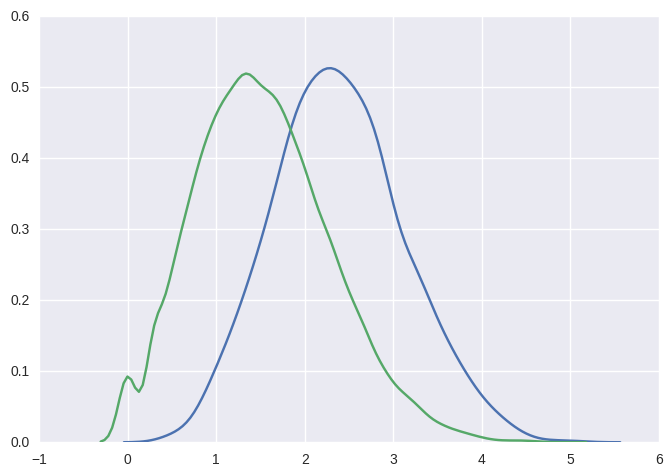

In [45]:
sns.kdeplot(np.log10(l_cp))
sns.kdeplot(np.log10(l_ncp))
plt.legend(["crossposting", "non-crossposting"])
plt.show()

In [67]:
m.shape, f.shape

((128122,), (43889,))

In [68]:
m1.shape, f1.shape

((1516987,), (107533,))

In [69]:
m.mean(), f.mean()

(25.345147593699753, 31.346259882886372)

In [70]:
m1.mean(), f1.mean()

(21.640137984043371, 26.575441957352627)